# ***DESI Human Glioma Section Spectra Clinical State Classification***

This notebook shows the process of section spectra clinical state classification of the DESI Human Glioma preprocessed dataset.

### ***Import packages***

Before we begin, let"s import all the necessary packages for this notebook.
First we add the directory which has our python files:

In [2]:
import sys
sys.path.insert(0, "../..")

Next we import all the necessary packages for this notebook:

In [3]:
import gc
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Tuple
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage import (filters)
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser, getionimage

### ***Constants definitions***

Next, let"s define some constant variables for this notebook:

In [4]:
# Define folder that contains the dhg dataset and files
DHG_PATH = "C:/Users/Leor/Desktop/Thesis/DHG"
# Define folder that contains the preprocessed dhg dataset
DHG_IN_PATH = f"{DHG_PATH}/Preprocessed"
# Define file that contains dhg clinical state annotations
CLINICAL_STATE_ANNOTATIONS_PATH = f"{DHG_PATH}/Clinical_state_annotations.csv"
# Define folder to save classification models for later use
MODELS_PATH = "C:/Users/Leor/Desktop/Thesis/replica_classification_models"
# Classification model number of epochs
EPHOCS = 50
# Classification model batch size
BATCH_SIZE = 256
# Classification model learning rate
LEARNING_RATE = 1e-3
# MSI Spectra dimension
SPECTRA_DIM = 92000
# The MSI sample type for filtering
SAMPLE_TYPE = "r"
# Mz value to get in order to threshold for tissue
TRESH_MZ = 750
# Mz tolerance value to get in order to threshold for tissue
TRESH_MZ_TOL = 150
# Treshould standard deviation for Gaussian kernel
TRESH_GAUSSIAN_SIGMA = 1.5 

### ***Reading MSI clinical state anotations***

Next, lets read the clinical state anotations for each MSI:

In [5]:
# Read clinical state annotations csv
clinical_state_df = pd.read_csv(CLINICAL_STATE_ANNOTATIONS_PATH)

# Filter by sample_type
clinical_state_df = clinical_state_df[clinical_state_df["sample_type"] ==
                                      SAMPLE_TYPE]

### ***Get all tissue spectra from all MSI:***

Next, let"s get all informations except intensities (which need a lot of memory) for each tissue spectra from all MSI:

In [6]:
# Create lists to store each spectra's info
file_names = []
sample_numbers = []
histologies = []
who_grades = []
x_coordinates = []
y_coordinates = []
idxs = []

# Loop over each MSI
for index, msi_row in tqdm(clinical_state_df.iterrows(),
                           total=clinical_state_df.shape[0],
                           desc="MSI Loop"):
  # Parse the MSI file
  with ImzMLParser(os.path.join(DHG_IN_PATH,
                                f"{msi_row.file_name}.imzML")) as reader:
    # Get local TIC image of msi in mz region [600, 900]
    local_tic_img = getionimage(reader, TRESH_MZ, tol=TRESH_MZ_TOL)

    # Threshold image to separate tissue spectra from background
    smooth = filters.gaussian(local_tic_img, sigma=TRESH_GAUSSIAN_SIGMA)
    thresh_mean = filters.threshold_mean(smooth)
    thresh_img = local_tic_img > thresh_mean

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                               total=len(reader.coordinates),
                               desc="Spectra Loop"):
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        # Keep sample file name of spectra
        file_names.append(msi_row.file_name)
        # Keep sample number of spectra
        sample_numbers.append(msi_row.sample_number)
        # Keep sample histology of spectra
        histologies.append(msi_row.histology)
        # Keep sample who grade of spectra
        who_grades.append(msi_row.who_grade)
        # Keep x coordinate of spectra
        x_coordinates.append(x)
        # Keep y coordinate of spectra
        y_coordinates.append(y)
        # Keep  of spectra
        idxs.append(idx)

# Convert to numpy array
file_names = np.array(file_names)
sample_numbers = np.array(sample_numbers)
histologies = np.array(histologies)
who_grades = np.array(who_grades)
x_coordinates = np.array(x_coordinates)
y_coordinates = np.array(y_coordinates)
idxs = np.array(idxs)
labels = (who_grades > 2).astype(int)

MSI Loop: 100%|██████████| 24/24 [02:52<00:00,  7.20s/it]


### ***MSI parsers opening:***

Next, let"s create parser for each MSI in order to read spectra's for the model:

In [7]:
# Opening parsers
parsers = {
    file_name: ImzMLParser(os.path.join(DHG_IN_PATH, f"{file_name}.imzML"))
    for file_name in clinical_state_df.file_name.unique()
}

### ***Dataset generator:***

Next, let"s create a dataset generator for the model:

In [8]:
def map_index(index: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map index to model input (spectra) and output (label).

  Args:
      index (tf.Tensor): index to map to corresponding values.

  Returns:
      Tuple[np.ndarray, int]: input (spectra) and output (label).
  
  """
  # Decoding index from the EagerTensor object
  index = index.numpy()
  # Reading spectra from parser
  file_name = file_names[index]
  idx = idxs[index]
  _, spectra = parsers[file_name].getspectrum(idx)
  # Return spectra and label
  return (spectra, labels[index])


def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): input (spectra)
      y (tf.Tensor): output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(indexes: np.ndarray, batch_size: int) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      indexes (np.ndarray): indexes of thh dataset
      batch_size (int): batch size

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset from indexes
  ds = tf.data.Dataset.from_tensor_slices(indexes)
  # Shuffle the data
  ds = ds.shuffle(len(indexes))
  # Map index to spectra
  ds = ds.map(lambda i: tf.py_function(
      func=map_index, inp=[i], Tout=[tf.float32, tf.float32]))
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batchs to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let"s create a classification dense neural network model:

In [9]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.Dense(512, activation='relu'),
      layers.Dense(512, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(1, activation='sigmoid')
    ]
  )

### ***LOOCV Classification:***

Next, let"s apply classification using LOOCV for best evaluation:

In [10]:
# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  train_filter = (sample_numbers != exclude_sample)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(train_indexes,
                                                test_size=0.2,
                                                random_state=0,
                                                stratify=labels[train_filter])

  # Create data generators
  training_generator = create_ds(train_indexes, BATCH_SIZE)
  validation_generator = create_ds(val_indexes, BATCH_SIZE)
  test_generator = create_ds(indexes[~train_filter], BATCH_SIZE)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False,
      monitor="val_accuracy",
      mode="max",
      save_best_only=True)
  
  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001)

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(), metrics=["accuracy"])

  # Train the classification model
  history = classification_model.fit(
      x=training_generator,
      validation_data=validation_generator,
      epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback])

  # Load the best saved 
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evalute the classification model on test set
  test_eval = classification_model.evaluate(x=test_generator)

  # Clean model for next iteration
  classification_model = None

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/50
127/127 [==============================] - 39s 297ms/step - loss: 0.3502 - accuracy: 0.8339 - val_loss: 0.1959 - val_accuracy: 0.9339
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_2\assets
Epoch 2/50
127/127 [==============================] - 29s 230ms/step - loss: 0.0380 - accuracy: 0.9884 - val_loss: 0.0085 - val_accuracy: 0.9980
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_2\assets
Epoch 3/50
127/127 [==============================] - 30s 234ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0075 - val_accuracy: 0.9980
Epoch 4/50
127/127 [==============================] - 30s 233ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0093 - val_accuracy: 0.9972
Epoch 5/50
127/127 [==============================] - 30s 240ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.0057 - val_accuracy: 0.9990
INFO:tensorflow:Assets written to: C:/Users/Leor/De

  5%|▍         | 1/22 [05:20<1:52:13, 320.66s/it]

Epoch 1/50
126/126 [==============================] - 30s 234ms/step - loss: 0.4064 - accuracy: 0.7865 - val_loss: 0.1856 - val_accuracy: 0.9407
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_3\assets
Epoch 2/50
126/126 [==============================] - 29s 233ms/step - loss: 0.1339 - accuracy: 0.9511 - val_loss: 0.0242 - val_accuracy: 0.9922
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_3\assets
Epoch 3/50
126/126 [==============================] - 30s 238ms/step - loss: 0.0085 - accuracy: 0.9971 - val_loss: 0.0107 - val_accuracy: 0.9970
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_3\assets
Epoch 4/50
126/126 [==============================] - 30s 238ms/step - loss: 0.1753 - accuracy: 0.9648 - val_loss: 0.0064 - val_accuracy: 0.9991
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classificati

  9%|▉         | 2/22 [10:33<1:45:15, 315.77s/it]

Epoch 1/50
133/133 [==============================] - 33s 249ms/step - loss: 0.4184 - accuracy: 0.7787 - val_loss: 0.1730 - val_accuracy: 0.9430
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_4\assets
Epoch 2/50
133/133 [==============================] - 31s 234ms/step - loss: 0.0895 - accuracy: 0.9630 - val_loss: 0.0317 - val_accuracy: 0.9948
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_4\assets
Epoch 3/50
133/133 [==============================] - 32s 238ms/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 0.0037 - val_accuracy: 0.9991
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_4\assets
Epoch 4/50
133/133 [==============================] - 32s 242ms/step - loss: 3.6178e-04 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 0.9994
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classifi

 14%|█▎        | 3/22 [15:25<1:36:41, 305.32s/it]

Epoch 1/50
132/132 [==============================] - 31s 234ms/step - loss: 0.4411 - accuracy: 0.7646 - val_loss: 0.1794 - val_accuracy: 0.9420
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_5\assets
Epoch 2/50
132/132 [==============================] - 30s 228ms/step - loss: 0.0938 - accuracy: 0.9659 - val_loss: 0.0228 - val_accuracy: 0.9925
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_5\assets
Epoch 3/50
132/132 [==============================] - 31s 237ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0046 - val_accuracy: 0.9987
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_5\assets
Epoch 4/50
132/132 [==============================] - 30s 227ms/step - loss: 2.1611e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9994
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classifi

 18%|█▊        | 4/22 [20:18<1:30:06, 300.35s/it]

Epoch 1/50
131/131 [==============================] - 31s 233ms/step - loss: 0.4681 - accuracy: 0.7463 - val_loss: 0.1922 - val_accuracy: 0.9386
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_6\assets
Epoch 2/50
131/131 [==============================] - 31s 234ms/step - loss: 0.1388 - accuracy: 0.9487 - val_loss: 0.0448 - val_accuracy: 0.9912
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_6\assets
Epoch 3/50
131/131 [==============================] - 30s 225ms/step - loss: 0.0131 - accuracy: 0.9961 - val_loss: 0.0053 - val_accuracy: 0.9990
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_6\assets
Epoch 4/50
131/131 [==============================] - 31s 233ms/step - loss: 4.6251e-04 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 0.9992
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classifi

 23%|██▎       | 5/22 [25:03<1:23:32, 294.86s/it]

Epoch 1/50
132/132 [==============================] - 31s 231ms/step - loss: 0.4359 - accuracy: 0.7757 - val_loss: 0.1820 - val_accuracy: 0.9418
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_7\assets
Epoch 2/50
132/132 [==============================] - 31s 232ms/step - loss: 0.1552 - accuracy: 0.9459 - val_loss: 0.0960 - val_accuracy: 0.9419
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_7\assets
Epoch 3/50
132/132 [==============================] - 29s 222ms/step - loss: 0.0377 - accuracy: 0.9810 - val_loss: 0.0078 - val_accuracy: 0.9983
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_7\assets
Epoch 4/50
132/132 [==============================] - 31s 234ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0035 - val_accuracy: 0.9994
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classificati

 27%|██▋       | 6/22 [30:22<1:20:48, 303.03s/it]

Epoch 1/50
127/127 [==============================] - 30s 232ms/step - loss: 0.4232 - accuracy: 0.7686 - val_loss: 0.1827 - val_accuracy: 0.9397
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_8\assets
Epoch 2/50
127/127 [==============================] - 31s 244ms/step - loss: 0.0924 - accuracy: 0.9626 - val_loss: 0.1938 - val_accuracy: 0.9314
Epoch 3/50
127/127 [==============================] - 30s 240ms/step - loss: 0.0117 - accuracy: 0.9964 - val_loss: 0.0029 - val_accuracy: 0.9994
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_8\assets
Epoch 4/50
127/127 [==============================] - 30s 236ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0025 - val_accuracy: 0.9994
Epoch 5/50
127/127 [==============================] - 30s 238ms/step - loss: 1.2655e-04 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 0.9994
Epoch 6/50
127/127 [===========================

 32%|███▏      | 7/22 [35:34<1:16:29, 305.98s/it]

Epoch 1/50
131/131 [==============================] - 32s 242ms/step - loss: 0.4419 - accuracy: 0.7616 - val_loss: 0.1813 - val_accuracy: 0.9408
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_9\assets
Epoch 2/50
131/131 [==============================] - 31s 236ms/step - loss: 0.0698 - accuracy: 0.9736 - val_loss: 0.0110 - val_accuracy: 0.9982
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_9\assets
Epoch 3/50
131/131 [==============================] - 32s 242ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0179 - val_accuracy: 0.9935
Epoch 4/50
131/131 [==============================] - 31s 239ms/step - loss: 9.1209e-04 - accuracy: 0.9999 - val_loss: 0.0021 - val_accuracy: 0.9993
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_9\assets
Epoch 5/50
131/131 [==============================] - 32s 241ms/step - loss: 3.2

 36%|███▋      | 8/22 [40:58<1:12:42, 311.60s/it]

Epoch 1/50
129/129 [==============================] - 30s 228ms/step - loss: 0.4209 - accuracy: 0.7839 - val_loss: 0.1819 - val_accuracy: 0.9423
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_10\assets
Epoch 2/50
129/129 [==============================] - 31s 236ms/step - loss: 0.1030 - accuracy: 0.9618 - val_loss: 0.0127 - val_accuracy: 0.9972
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_10\assets
Epoch 3/50
129/129 [==============================] - 31s 239ms/step - loss: 0.1321 - accuracy: 0.9654 - val_loss: 0.1445 - val_accuracy: 0.9423
Epoch 4/50
129/129 [==============================] - 30s 233ms/step - loss: 0.0246 - accuracy: 0.9926 - val_loss: 0.0047 - val_accuracy: 0.9993
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_10\assets
Epoch 5/50
129/129 [==============================] - 30s 233ms/step - loss: 0.00

 41%|████      | 9/22 [48:49<1:18:20, 361.56s/it]

Epoch 1/50
133/133 [==============================] - 32s 241ms/step - loss: 0.3965 - accuracy: 0.7963 - val_loss: 0.1790 - val_accuracy: 0.9432
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_11\assets
Epoch 2/50
133/133 [==============================] - 32s 237ms/step - loss: 0.1000 - accuracy: 0.9611 - val_loss: 0.0128 - val_accuracy: 0.9965
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_11\assets
Epoch 3/50
133/133 [==============================] - 33s 247ms/step - loss: 0.1416 - accuracy: 0.9721 - val_loss: 0.0127 - val_accuracy: 0.9983
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_11\assets
Epoch 4/50
133/133 [==============================] - 35s 260ms/step - loss: 0.0045 - accuracy: 0.9994 - val_loss: 0.0055 - val_accuracy: 0.9986
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classific

 45%|████▌     | 10/22 [54:26<1:10:45, 353.80s/it]

Epoch 1/50
132/132 [==============================] - 31s 233ms/step - loss: 0.4364 - accuracy: 0.7660 - val_loss: 0.2042 - val_accuracy: 0.9294
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_12\assets
Epoch 2/50
132/132 [==============================] - 30s 227ms/step - loss: 0.1351 - accuracy: 0.9511 - val_loss: 0.0304 - val_accuracy: 0.9908
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_12\assets
Epoch 3/50
132/132 [==============================] - 33s 251ms/step - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.0048 - val_accuracy: 0.9989
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_12\assets
Epoch 4/50
132/132 [==============================] - 32s 242ms/step - loss: 2.9708e-04 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 0.9990
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_class

 50%|█████     | 11/22 [59:23<1:01:42, 336.63s/it]

Epoch 1/50
127/127 [==============================] - 31s 241ms/step - loss: 0.4334 - accuracy: 0.7673 - val_loss: 0.1804 - val_accuracy: 0.9421
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_13\assets
Epoch 2/50
127/127 [==============================] - 31s 243ms/step - loss: 0.1459 - accuracy: 0.9552 - val_loss: 0.3648 - val_accuracy: 0.8254
Epoch 3/50
127/127 [==============================] - 32s 248ms/step - loss: 0.2179 - accuracy: 0.9247 - val_loss: 0.0141 - val_accuracy: 0.9975
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_13\assets
Epoch 4/50
127/127 [==============================] - 30s 231ms/step - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0149 - val_accuracy: 0.9963
Epoch 5/50
127/127 [==============================] - 31s 245ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0044 - val_accuracy: 0.9989
INFO:tensorflow:Assets written to: C:/Users/Leor/

 55%|█████▍    | 12/22 [1:04:43<55:13, 331.34s/it]

Epoch 1/50
128/128 [==============================] - 32s 250ms/step - loss: 0.4572 - accuracy: 0.7475 - val_loss: 0.1856 - val_accuracy: 0.9398
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_14\assets
Epoch 2/50
128/128 [==============================] - 32s 253ms/step - loss: 0.1162 - accuracy: 0.9571 - val_loss: 0.0238 - val_accuracy: 0.9925
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_14\assets
Epoch 3/50
128/128 [==============================] - 32s 248ms/step - loss: 0.0435 - accuracy: 0.9880 - val_loss: 0.0082 - val_accuracy: 0.9980
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_14\assets
Epoch 4/50
128/128 [==============================] - 31s 244ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.0083 - val_accuracy: 0.9980
Epoch 5/50
128/128 [==============================] - 32s 249ms/step - loss: 6.15

 59%|█████▉    | 13/22 [1:10:42<50:59, 339.98s/it]

Epoch 1/50
131/131 [==============================] - 32s 239ms/step - loss: 0.4350 - accuracy: 0.7666 - val_loss: 0.1757 - val_accuracy: 0.9454
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_15\assets
Epoch 2/50
131/131 [==============================] - 30s 226ms/step - loss: 0.1682 - accuracy: 0.9458 - val_loss: 0.1490 - val_accuracy: 0.9462
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_15\assets
Epoch 3/50
131/131 [==============================] - 31s 235ms/step - loss: 0.0513 - accuracy: 0.9756 - val_loss: 0.0056 - val_accuracy: 0.9984
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_15\assets
Epoch 4/50
131/131 [==============================] - 31s 237ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0031 - val_accuracy: 0.9987
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classific

 64%|██████▎   | 14/22 [1:16:38<45:58, 344.81s/it]

Epoch 1/50
131/131 [==============================] - 31s 238ms/step - loss: 0.4282 - accuracy: 0.7759 - val_loss: 0.1761 - val_accuracy: 0.9408
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_16\assets
Epoch 2/50
131/131 [==============================] - 31s 235ms/step - loss: 0.0843 - accuracy: 0.9679 - val_loss: 0.0091 - val_accuracy: 0.9980
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_16\assets
Epoch 3/50
131/131 [==============================] - 31s 238ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0080 - val_accuracy: 0.9983
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_16\assets
Epoch 4/50
131/131 [==============================] - 32s 244ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.0055 - val_accuracy: 0.9992
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classific

 68%|██████▊   | 15/22 [1:22:10<39:45, 340.72s/it]

Epoch 1/50
121/121 [==============================] - 29s 240ms/step - loss: 0.4547 - accuracy: 0.7648 - val_loss: 0.1829 - val_accuracy: 0.9354
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_18\assets
Epoch 2/50
121/121 [==============================] - 29s 235ms/step - loss: 0.1333 - accuracy: 0.9429 - val_loss: 0.0573 - val_accuracy: 0.9904
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_18\assets
Epoch 3/50
121/121 [==============================] - 29s 239ms/step - loss: 0.2072 - accuracy: 0.9565 - val_loss: 0.0262 - val_accuracy: 0.9945
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_18\assets
Epoch 4/50
121/121 [==============================] - 29s 240ms/step - loss: 0.0097 - accuracy: 0.9990 - val_loss: 0.0086 - val_accuracy: 0.9988
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classific

 73%|███████▎  | 16/22 [1:29:43<37:28, 374.70s/it]

Epoch 1/50
132/132 [==============================] - 34s 252ms/step - loss: 0.4101 - accuracy: 0.7931 - val_loss: 0.1840 - val_accuracy: 0.9399
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_19\assets
Epoch 2/50
132/132 [==============================] - 33s 248ms/step - loss: 0.1644 - accuracy: 0.9470 - val_loss: 0.1660 - val_accuracy: 0.9415
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_19\assets
Epoch 3/50
132/132 [==============================] - 32s 241ms/step - loss: 0.1977 - accuracy: 0.9601 - val_loss: 1.3144 - val_accuracy: 0.5934
Epoch 4/50
132/132 [==============================] - 32s 245ms/step - loss: 0.6978 - accuracy: 0.5934 - val_loss: 0.6759 - val_accuracy: 0.5934
Epoch 5/50
132/132 [==============================] - 32s 245ms/step - loss: 0.6751 - accuracy: 0.5934 - val_loss: 0.6727 - val_accuracy: 0.5934
Epoch 6/50
132/132 [=============================

 77%|███████▋  | 17/22 [1:37:28<33:28, 401.80s/it]

Epoch 1/50
129/129 [==============================] - 32s 245ms/step - loss: 0.4644 - accuracy: 0.7578 - val_loss: 0.1846 - val_accuracy: 0.9378
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_20\assets
Epoch 2/50
129/129 [==============================] - 32s 250ms/step - loss: 0.1583 - accuracy: 0.9460 - val_loss: 0.1033 - val_accuracy: 0.9400
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_20\assets
Epoch 3/50
129/129 [==============================] - 32s 244ms/step - loss: 0.0175 - accuracy: 0.9924 - val_loss: 0.0060 - val_accuracy: 0.9990
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_20\assets
Epoch 4/50
129/129 [==============================] - 32s 247ms/step - loss: 7.5900e-04 - accuracy: 0.9998 - val_loss: 0.0056 - val_accuracy: 0.9992
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_class

 82%|████████▏ | 18/22 [1:42:21<24:36, 369.10s/it]

Epoch 1/50
129/129 [==============================] - 30s 229ms/step - loss: 0.3475 - accuracy: 0.8149 - val_loss: 0.0177 - val_accuracy: 0.9963
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_21\assets
Epoch 2/50
129/129 [==============================] - 31s 242ms/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.0055 - val_accuracy: 0.9989
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_21\assets
Epoch 3/50
129/129 [==============================] - 30s 232ms/step - loss: 8.2569e-04 - accuracy: 0.9998 - val_loss: 0.0054 - val_accuracy: 0.9990
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_21\assets
Epoch 4/50
129/129 [==============================] - 31s 241ms/step - loss: 1.8153e-04 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 0.9990
Epoch 5/50
129/129 [==============================] - 31s 243ms/step - lo

 86%|████████▋ | 19/22 [1:47:09<17:13, 344.66s/it]

Epoch 1/50
131/131 [==============================] - 32s 243ms/step - loss: 0.4450 - accuracy: 0.7709 - val_loss: 0.1807 - val_accuracy: 0.9402
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_23\assets
Epoch 2/50
131/131 [==============================] - 30s 229ms/step - loss: 0.1306 - accuracy: 0.9532 - val_loss: 0.0283 - val_accuracy: 0.9941
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_23\assets
Epoch 3/50
131/131 [==============================] - 32s 247ms/step - loss: 0.1828 - accuracy: 0.9609 - val_loss: 0.0221 - val_accuracy: 0.9956
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_23\assets
Epoch 4/50
131/131 [==============================] - 30s 231ms/step - loss: 0.0059 - accuracy: 0.9993 - val_loss: 0.0081 - val_accuracy: 0.9978
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classific

 91%|█████████ | 20/22 [1:53:43<11:58, 359.46s/it]

Epoch 1/50
129/129 [==============================] - 31s 242ms/step - loss: 0.4286 - accuracy: 0.7783 - val_loss: 0.1833 - val_accuracy: 0.9383
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_25\assets
Epoch 2/50
129/129 [==============================] - 30s 234ms/step - loss: 0.1628 - accuracy: 0.9458 - val_loss: 0.1409 - val_accuracy: 0.9406
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_25\assets
Epoch 3/50
129/129 [==============================] - 31s 243ms/step - loss: 0.1888 - accuracy: 0.9500 - val_loss: 0.0303 - val_accuracy: 0.9949
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_25\assets
Epoch 4/50
129/129 [==============================] - 32s 243ms/step - loss: 0.0117 - accuracy: 0.9983 - val_loss: 0.0101 - val_accuracy: 0.9984
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classific

 95%|█████████▌| 21/22 [2:00:12<06:08, 368.45s/it]

Epoch 1/50
127/127 [==============================] - 32s 246ms/step - loss: 0.4513 - accuracy: 0.7646 - val_loss: 0.1905 - val_accuracy: 0.9317
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_29\assets
Epoch 2/50
127/127 [==============================] - 30s 238ms/step - loss: 0.2164 - accuracy: 0.9215 - val_loss: 0.3488 - val_accuracy: 0.8513
Epoch 3/50
127/127 [==============================] - 31s 245ms/step - loss: 0.1890 - accuracy: 0.9425 - val_loss: 0.1779 - val_accuracy: 0.9398
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/replica_classification_models\excluded_29\assets
Epoch 4/50
127/127 [==============================] - 31s 245ms/step - loss: 0.1640 - accuracy: 0.9462 - val_loss: 0.1776 - val_accuracy: 0.9398
Epoch 5/50
127/127 [==============================] - 31s 245ms/step - loss: 0.1637 - accuracy: 0.9463 - val_loss: 0.1767 - val_accuracy: 0.9398
Epoch 6/50
127/127 [=============================

100%|██████████| 22/22 [2:08:14<00:00, 349.76s/it]


### ***LOOCV predictions:***

Next, let"s get predictions for each LOOCV for evaluation:

In [11]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()
  
  # Create filter for training data
  train_filter = (sample_numbers != exclude_sample)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[~train_filter], BATCH_SIZE)

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)
  
  # Get corresponding true labels
  true_labels[exclude_sample] = (who_grades[~train_filter] > 2).astype(int)

  # Clean model for next iteration
  classification_model = None

100%|██████████| 22/22 [01:14<00:00,  3.40s/it]


### ***Roc curve:***

Next, let"s plot LOOCV roc curve:

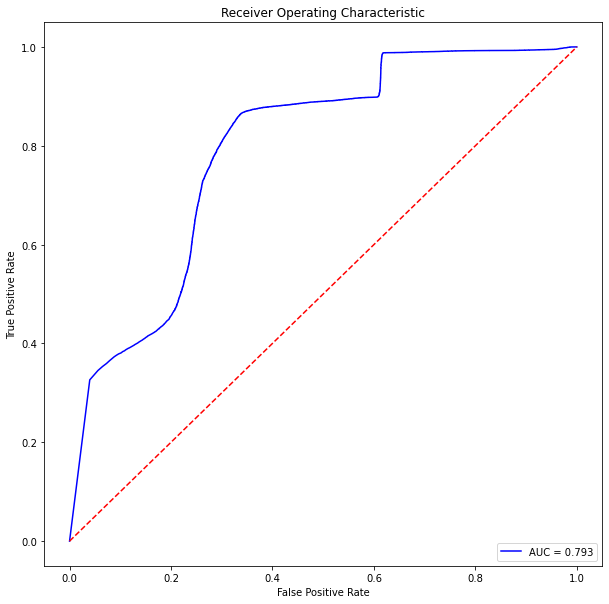

In [12]:
fpr, tpr, thresholds = metrics.roc_curve(
  np.concatenate(list(true_labels.values())),
  np.concatenate(list(predictions.values())))
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, "b", label = f"AUC = {roc_auc:.3f}")
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1],"r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [13]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()